In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange, tqdm

In [9]:
path_datasets = Path('./datasets')

ls = [f for f in path_datasets.glob('*') if f.is_file()]
ls

[PosixPath('datasets/test.csv'),
 PosixPath('datasets/train.csv'),
 PosixPath('datasets/sample_submission.csv')]

In [10]:
_data = np.loadtxt(ls[1], skiprows=1, delimiter=',')

X = _data[:, 1:]
Y = _data[:,0]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
X_test, X_eval, Y_test, Y_eval = train_test_split(X_test, Y_test, test_size=0.5)

print(f'{X_train.shape=}')
print(f'{X_test.shape=}')
print(f'{X_eval.shape=}')
print()

print(f'{Y_train.shape=}')
print(f'{Y_test.shape=}')
print(f'{Y_eval.shape=}')

X_train.shape=(29400, 784)
X_test.shape=(6300, 784)
X_eval.shape=(6300, 784)

Y_train.shape=(29400,)
Y_test.shape=(6300,)
Y_eval.shape=(6300,)


## Pytorch

In [29]:
import torch
from torch import nn
import torch.nn.functional as F
torch.set_warn_always(True)

# # check if torch supports mac gpu
# if torch.backends.mps.is_available() and\
#     torch.backends.mps.is_built():
#     device = torch.device("mps")
    
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

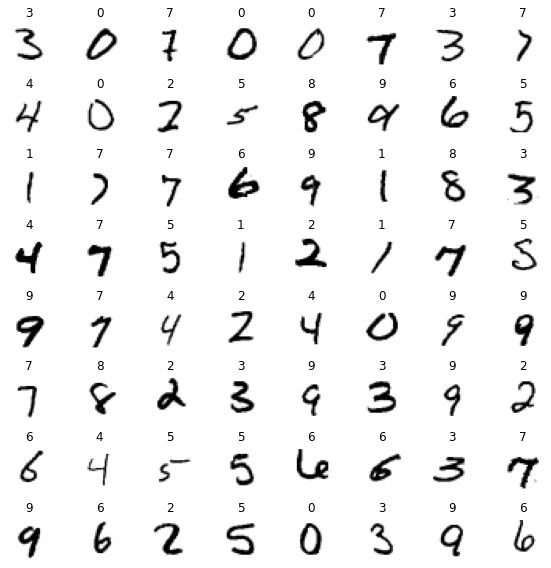

In [12]:
G = 8

figure = plt.figure(figsize=(G, G))

for i in np.arange(G*G):
    sample_idx = np.random.choice(np.arange(len(X_train)), G*G, replace=False)
    img, label = X_train[sample_idx[i]], Y_train[sample_idx[i]]
    figure.add_subplot(G, G, i + 1)
    plt.title(int(label))
    plt.axis("off")
    plt.imshow(img.reshape((28,28)), cmap="gray_r")
plt.tight_layout()
plt.show()

In [13]:
class TinyModel(nn.Module):
    def __init__(self):
        super(TinyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
# def train(model, device, train_loader, optimizer, epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.nll_loss(output, target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 10 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))

# def test(model, device, test_loader):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(test_loader.dataset)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))


  0%|          | 0/500 [00:00<?, ?it/s]

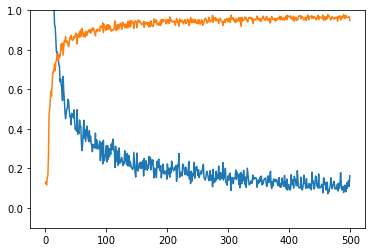

CPU times: user 4min 32s, sys: 1min 32s, total: 6min 4s
Wall time: 49.8 s


In [57]:
%%time

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = TinyModel()
model.to(device)

BATCH_SIZE = 512
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
losses, accuracies = [], []

model.train()
for i in (t:= trange(500)):
    samp = np.random.choice(range(X_train.shape[0]), size = BATCH_SIZE, replace=False)
    X = torch.tensor(X_train[samp].reshape((len(samp), 1, 28, 28)), dtype=torch.float32)
    X = X.to(device)
    Y = torch.tensor(Y_train[samp], dtype=torch.long)
    Y = Y.to(device)
    optim.zero_grad() #zero_grad
    out = model(X)
    loss = F.nll_loss(out, Y)
    loss.backward()
    optim.step()
    
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    
    t.set_description(f"loss {loss:.2f}, accuracy {accuracy:.2f}")
    
    
plt.ylim(-0.1,1)
plt.plot(losses)
plt.plot(accuracies)
plt.show()

In [ ]:
"""
    batch:128
    its:1000
    cpu: 28 it/s
    wall time: 35
    
    batch:128
    its:1000
    cpu: 55 it/s
    wall time: 18.5
    
    batch:512
    its:500
    cpu: 28 it/s
    wall time: 26
"""

In [ ]:
# evaluation

model.to('cpu')

out = model(torch.tensor(X_train.reshape((-1, 1, 28, 28)), dtype=torch.float32))
Y_train_preds = torch.argmax(out, dim=1)
(Y_train == Y_train_preds).mean()

In [1]:
"""
MNIST with PyTorch on Apple Silicon GPU
Script will be linked in the description as a Github Gist.
Install PyTorch nightly with this command:
pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
Code borrowed from PyTorch Examples.
"""

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

EPOCHS = 5

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)

    device = torch.device("mps")
    print("Using Device: ", device)

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=128, shuffle=True)


    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    for epoch in range(1, EPOCHS + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

if __name__ == "__main__":
    main()

PyTorch version: 1.13.0.dev20220828
Torchvision version: 0.14.0.dev20220828
Using Device:  mps
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308341
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.284214
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.213376
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.107417
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.006507
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.791899
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.371938
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.025247
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.729037
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.629198
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.518548
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.464692
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.416113
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.398499
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.368194
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.240478
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.210963
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.356670
Train Epoch: 1 [23040

Train Epoch: 4 [24320/60000 (41%)]	Loss: 0.036236
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.020764
Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.022202
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.061943
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.032578
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.028929
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.072801
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.069804
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.068092
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.092522
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.123120
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.032781
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.103570
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.048387
Train Epoch: 4 [42240/60000 (70%)]	Loss: 0.052824
Train Epoch: 4 [43520/60000 (72%)]	Loss: 0.067356
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.026014
Train Epoch: 4 [46080/60000 (77%)]	Loss: 0.070667
Train Epoch: 4 [47360/60000 (79%)]	Loss: 0.131130
Train Epoch: 4 [48640/60000 (81%)]	Loss: 0.016761


In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)

In [23]:
for (data, target) in train_loader:
    break
    
data

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

In [26]:
data.dtype

torch.float32